In [1]:
import numpy as np
import pandas as pd
import csv
import itertools
from scipy.special import logsumexp
import scipy.optimize as sciop
import time

In [98]:
# PATH = './'
PATH = './../../Assignment2/Assignment2/'

In [251]:
transition_gradient = pd.read_csv(PATH + 'model/transition-gradient.txt', delimiter=' ', header=None)
transition_params = pd.read_csv(PATH + 'model/transition-params.txt', delimiter=' ', header=None)
feature_gradient = pd.read_csv(PATH + 'model/feature-gradient.txt', delimiter=' ', header=None)
feature_params = pd.read_csv(PATH + 'model/feature-params.txt', delimiter=' ', header=None)

feature_params = feature_params.values
transition_params = transition_params.values

In [4]:
train_labels = open(PATH + 'data/train_words.txt').read().splitlines()
test_labels = open(PATH + 'data/test_words.txt').read().splitlines()

In [5]:
AllChars = "etainoshrd"
CharMapping = \
{'e': 0,
 't': 1,
 'a': 2,
 'i': 3,
 'n': 4,
 'o': 5,
 's': 6,
 'h': 7,
 'r': 8,
 'd': 9
}
featSize=321

In [6]:
pd.set_option('display.float_format', '{:.4e}'.format)
# pd.reset_option('display.float_format')

In [7]:
####### Load all training words #####
AlltrainWords = []
for trainWordIdx in range(0, 400):
    trainWord = pd.read_csv(PATH + 'data/train_img{}.txt'.format(trainWordIdx+1), header=None, delimiter=" ")
    trainWord = trainWord.values
    AlltrainWords.append(trainWord)

In [8]:
####### Load all testing words #####
AlltestWords = []
for testWordIdx in range(0, 200):
    testWord = pd.read_csv(PATH + 'data/test_img{}.txt'.format(testWordIdx+1), header=None, delimiter=" ")
    testWord = testWord.values
    AlltestWords.append(testWord)

In [122]:
def computePotentials(wordFeats, featureParams):
    """
    Compute single Node log potentials 
    wordFeats: X : (L, 321) 
    featureParams: W_F : (10, 321)
    Returns an array of log potentials for each position : (L, 321)
    """
    wF_times_X = featureParams @ wordFeats.T # np.multiply(featureParams, wordFeats.T)
    return wF_times_X.values

In [252]:
def computeEnergy(wordFeats, wordLabel, logPotentials, transitionParams):
    """
    Compute Energy of a given word, E = - sum log(potential) + W_T
    wordFeats: X : (L, 321)
    Returns computed energy
    """
    wordLabel_CharIdx = [CharMapping[x] for x in wordLabel]
    sum_phis = np.sum(logPotentials[wordLabel_CharIdx, range(0, len(wordFeats))])
    
    arr = [(x, y) for (x, y) in zip(wordLabel_CharIdx[:-1], wordLabel_CharIdx[1:])]
    transition_param_sum = 0
    for elem in arr:
        trainsition_param_sum += transitionParams[elem]
#         transition_param_sum += transitionParams.iloc[elem]
    return transition_param_sum + sum_phis
    

In [244]:
####### Nodes are 1 indexed
def messageDict(word, featParams, transParams, wordPhis=None):
    """
    Returns Messages dictionary for every pair of adjacent nodes
    word: X : (L, 321)
    featParams: W_F : (10, 321)
    transParams: W_T : (10, 10)
    wordPhis: Precomputed log potentials of the word
    
    Every element of dict has shape (10,)
    """
    ########### Compute Word Potentials #########
    if wordPhis is None:
        wordPhis = computePotentials(word, featParams)
        
    logM = dict()
    logM[len(word) + 1, len(word)] = np.zeros(len(AllChars))
    logM[0, 1] = np.zeros(len(AllChars))
    
    #### Backward Messages ####
    for fromNode in range(len(word), 1, -1):
        logM[fromNode, fromNode - 1] = logsumexp(wordPhis[:, fromNode-1] + \
                              logM[fromNode + 1, fromNode] + \
                              transParams.values, axis = 1)    
        
    #### Forward Messages ####
    for fromNode in range(1, len(word)):
        logM[fromNode, fromNode + 1] = logsumexp(wordPhis[:, fromNode-1] + \
                              logM[fromNode - 1, fromNode] + \
                                transParams.values.T, axis=1)    
    return logM

def singleVariableMarginal(node, word, featParams, transParams, wordPhis=None, logPartition=None, _messageDict=None):
    """
    Returns log Marginals
    """
    if wordPhis is None:
        wordPhis = computePotentials(word, featParams)
    
    if _messageDict is None:
        _messageDict = messageDict(word, featParams, transParams, wordPhis)
    if (node > 0):
        m_left = _messageDict[node-1, node]
    if (node < len(word)+1):
        m_right = _messageDict[node+1, node]
    
    total_incoming_message = m_left + m_right
    
    ############
    if (logPartition is None):
        logPartition = logsumexp(wordPhis[:, node-1] + total_incoming_message)
        
    logMarginalProbs = wordPhis[:, node-1] + total_incoming_message - logPartition
    return np.exp(logMarginalProbs)

def singleVariableMarginalWord(word, featParams, transParams, wordPhis=None, logPartition=None, _messageDict=None):
    """
    Returns log Marginals for each node
    """
    if wordPhis is None:
        wordPhis = computePotentials(word, featParams)
    
    if _messageDict is None:
        _messageDict = messageDict(word, featParams, transParams, wordPhis)
    
    ############
    if (logPartition is None):
        logPartition = logsumexp(wordPhis[:, 0] + _messageDict[2, 1])
        
    singleVarMargs = []
    for node in range(1, len(word)+1):
        sVM = singleVariableMarginal(node, word, featParams, transParams, wordPhis, logPartition, _messageDict)
        singleVarMargs.append(sVM)
        
    singleVarMargs = np.array(singleVarMargs)
    return singleVarMargs


def pairwiseMarginal(nodeL, nodeR, word, featParams, transParams, logPartition=None, wordPhis=None, _messageDict=None):
    """ 
    PairWise Marginal for nodeL and nodeR
    """
    if (wordPhis is None):
        wordPhis = computePotentials(word, featParams)
        
    if (_messageDict is None):
        _messageDict = messageDict(word, featParams, transParams, wordPhis)
    
    if (logPartition is None):
        logPartition = logsumexp(wordPhis[:, nodeL] + _messageDict[nodeL+1, nodeL] + _messageDict[nodeL-1, nodeL])
        
#     chars_to_consider = AllChars
#     pairwise_marginals = np.zeros( (len(chars_to_consider), len(chars_to_consider)) )
    
    mLeft = 0
    mRight = 0
    if (nodeL >= 1):
        mLeft = _messageDict[nodeL - 1, nodeL]
    if (nodeR <= len(word)):
        mRight = _messageDict[nodeR + 1, nodeR]
        
    logSingleMarginalsL = wordPhis[:, nodeL-1] + mLeft
    logSingleMarginalsR = wordPhis[:, nodeR-1] + mRight
#     logSingleMarginalsL = np.stack( [logSingleMarginalsL]*len(AllChars) ).T
#     logSingleMarginalsR = np.stack( [logSingleMarginalsR]*len(AllChars) )
    
    SingleMarginals = logSingleMarginalsL[None, ].T + logSingleMarginalsR[None, ]
    jointMarginal = SingleMarginals + transParams - logPartition

    return (jointMarginal)

def pairwiseMarginalWord(word, featParams, transParams, wordPhis=None, logPartition=None, _messageDict=None):
    """
    Pairwise Marginal for each pair of nodes
    """
    if wordPhis is None:
        wordPhis = computePotentials(word, featParams)
    if _messageDict is None:
        _messageDict = messageDict(word, featParams, transParams, wordPhis)
    if logPartition is None:
        logPartition = logsumexp(wordPhis[:, 0] + _messageDict[2, 1])
    
    pairwiseMargs = []
    for node in range(1, len(word)):
        pM = pairwiseMarginal(node, node+1, word, featParams, transParams, logPartition, wordPhis, _messageDict)
        pairwiseMargs.append(pM.values)
        
    pairwiseMargs = np.exp(np.array(pairwiseMargs))
    return pairwiseMargs

# Question 1:


In [250]:
####### Compute Log Likelihood ######
def loglikelihood(W, dataSize, AllWords, AllLabels):
    """
    Evaluated the average log likelihood (lll) of AllWords
    W: value of weights to comptue lll at
    dataSize: Consider 0->dataSize cases from AllWords to compute lll
    AllWords: Array containing all training word features
    AllLabels: True labels for each characeter of each training word
    
    Returns average loglikelihood evaluated at W (float)
    """
    wF, wT = W[:len(AllChars)*featSize], W[len(AllChars)*featSize:]
    wF = pd.DataFrame(np.reshape(wF, (len(AllChars), featSize)))
    wT = pd.DataFrame(np.reshape(wT, (len(AllChars), len(AllChars))))
    
    loglikelihood = 0
    for WordIdx in range(0, dataSize):
        Word = AllWords[WordIdx]
        Word_label = AllLabels[WordIdx]
        Word_labelIdxs = [CharMapping[x] for x in Word_label]

        WordPhis = computePotentials(Word, wF)
        WordlogM = messageDict(Word, wF, wT, WordPhis)
        marginal = WordPhis[:, 0] + WordlogM[(2, 1)]
        logZ = logsumexp(marginal)

        WordEnergy = computeEnergy(Word, Word_label, WordPhis, wT)
        loglikelihood += WordEnergy - logZ

#     print("Log likelihood for first {} train data points:".format(dataSize), loglikelihood/dataSize )
    return loglikelihood/dataSize

In [213]:
avglll = loglikelihood(np.append(feature_params.values.flatten(), transition_params.values.flatten()), \
                       50, AlltrainWords, train_labels)

Log likelihood for first 50 train data points: -4.58395903635572


In [245]:
def _computeGradWF(word, wordLabel, singleMarginals):
    """
    Compute the feature parameter gradient for a single word
    word: image features of the word
    wordLabel: true ground truth label
    singleMarginals: Marginal distribution of each node in CRF
    
    Returns 10 x 321 np array that contains the gradient of lll of 'word' w.r.t. W^T evaluated at current W
    """
    wordLabelList = np.array([x for x in wordLabel])
    mask = [np.where(wordLabelList == c)[0] for c in CharMapping] # 10 x L(word)
    selectedX = [np.sum(word[m, :], axis=0) for m in mask] # 10 x _ x 321

#     secondTerm = []
#     for c_id, c in enumerate(AllChars):
#         probbyc = np.expand_dims(singleMarginals[:, c_id], axis=1)
#         secondTerm.append(np.sum(word*probbyc, axis=0))
#     secondTerm = np.array(secondTerm)
#     print(secondTerm.shape)

    secondTerm = singleMarginals.T @ word
    grad = selectedX - secondTerm
    return grad

def computeGradF(wF, wT, dataSize, AlltrainingWords, trainingPotentials, Alltraininglabels):
    """
    Compute the feature parameter gradient for words in AlltrainingWords
    W: current value of weights
    dataSize: 0->dataSize words will be used from AlltrainingWords for computation of gradient
    AlltrainingWords: Array containing all training word features
    trainingPotentials: Precomputed node Potentials of every training word
    Alltraininglabels: True labels for each characeter of each training word
    
    Returns 10x321 array containing gradient of avg. lll w.r.t. W^F evaluated at W
    """
#     wF, wT = W[:len(AllChars)*featSize], W[len(AllChars)*featSize:]
#     wF = pd.DataFrame(np.reshape(wF, (len(AllChars), featSize)))
#     wT = pd.DataFrame(np.reshape(wT, (len(AllChars), len(AllChars))))
    grad = 0
    for trainWordIdx in range(dataSize):
        trainWord = AlltrainingWords[trainWordIdx]
        trainWord_label = Alltraininglabels[trainWordIdx]
        trainWord_labelIdxs = [CharMapping[x] for x in trainWord_label]
        trainWordPhis = trainingPotentials[trainWordIdx] # computePotentials(trainWord, wF)
        trainWord_messagesDict = messageDict(trainWord, wF, wT, trainWordPhis)
        trainWord_logPartition = logsumexp(trainWordPhis[:, 0] + trainWord_messagesDict[2, 1])

        st = time.time()
        singleVarMargs = singleVariableMarginalWord(trainWord, wF, wT, trainWordPhis, trainWord_logPartition, trainWord_messagesDict)
        et1 = time.time()
        grad += _computeGradWF(trainWord, trainWord_label, singleVarMargs)
        et2 = time.time()
#         print("Loop over nodes gradF:", et1 - st)
#         print("ComputeGrad F per word:", et2 - et1)
        
    return grad/dataSize

def _computeGradWT(word, wordLabel, _pairwiseMarginals):
    """
    Compute the transition parameter gradient for a single word
    word: image features of the word
    wordLabel: true ground truth label
    _pairwiseMarginals: Pairwise Marginal distribution of each pair of adjacent nodes in CRF
    
    Returns 10 x 10 np array that contains the gradient of lll of 'word' w.r.t. W^T evaluated at current W
    """
    gradwt = -1*np.sum(_pairwiseMarginals, axis=0)
    for letter_id in range(0, len(word)-1):
        gradwt[ CharMapping[wordLabel[letter_id]], CharMapping[wordLabel[letter_id + 1]] ] += 1
    
    return gradwt

def computeGradT(wF, wT, dataSize, AlltrainingWords, trainingPotentials, Alltraininglabels):
    """
    Compute Gradient for Transition parameters
    W: Current values of weights to evaluate the gradient at
    dataSize: size of the training data to be used
    AlltrainingWords: Array containing all training word features
    trainingPotentials: Precomputed node Potentials of every training word
    Alltraininglabels: True labels for each characeter of each training word
    
    Returns 10 x 10 np array containing the gradient of lll w.r.t. W^T evaluated at current W
    """
#     wF, wT = W[:len(AllChars)*featSize], W[len(AllChars)*featSize:]
#     wF = pd.DataFrame(np.reshape(wF, (len(AllChars), featSize)))
#     wT = pd.DataFrame(np.reshape(wT, (len(AllChars), len(AllChars))))
    gradWT = 0
    for trainWordIdx in range(dataSize):
        trainWord = AlltrainingWords[trainWordIdx]
        trainWord_label = Alltraininglabels[trainWordIdx]
        trainWord_labelIdxs = [CharMapping[x] for x in trainWord_label]
        trainWordPhis = trainingPotentials[trainWordIdx] # computePotentials(trainWord, wF)
        st = time.time()
        trainWord_messagesDict = messageDict(trainWord, wF, wT, trainWordPhis)
        et1 = time.time()
        trainWord_logPartition = logsumexp(trainWordPhis[:, 0] + trainWord_messagesDict[2, 1])

        start_time = time.time()
        pairwiseMargs = pairwiseMarginalWord(trainWord, wF, wT, trainWordPhis, trainWord_logPartition, trainWord_messagesDict)
        end_time1 = time.time()
#         print("messages computation:", et1 - st)
#         print("Pairwise for each word:", end_time1 - start_time)
        gradWT += _computeGradWT(trainWord, trainWord_label, np.array(pairwiseMargs))
        
    return gradWT/dataSize

In [247]:
def gradlll(W, dataSize, AlltrainingWords, Alltraininglabels):
    """ Compute the gradient of log likelihood at wF and wT """
    wF, wT = W[:len(AllChars)*featSize], W[len(AllChars)*featSize:]
    wF = pd.DataFrame(np.reshape(wF, (len(AllChars), featSize)))
    wT = pd.DataFrame(np.reshape(wT, (len(AllChars), len(AllChars))))
    
    trainingPotentials = []
    for dataIter in range(dataSize):
        thisWordPotential = computePotentials(AlltrainingWords[dataIter], wF)
        trainingPotentials.append(thisWordPotential)
    
    start_time = time.time()
    gradWF = computeGradF(wF, wT, dataSize, AlltrainingWords, trainingPotentials, Alltraininglabels)
    end_time1 = time.time()
    gradWT = computeGradT(wF, wT, dataSize, AlltrainingWords, trainingPotentials, Alltraininglabels)
    end_time2 = time.time()
#     print("Grad W computation time:", end_time1 - start_time)
#     print("Grad T computation time:", end_time2 - end_time1 )
    
    grads = np.concatenate( (gradWF.flatten(), gradWT.flatten()) )
    return grads

In [248]:
######## Verify the computation of gradients is correct
W0 = np.append(feature_params.values.flatten(), (transition_params.values.flatten()))
_grads_ll = gradlll(W0, 50, AlltrainWords, train_labels)
_wF, _wT = _grads_ll[:len(AllChars)*featSize], _grads_ll[ len(AllChars)*featSize: ]
_wF = pd.DataFrame(np.reshape(_wF, (len(AllChars), featSize)))
_wT = pd.DataFrame(np.reshape(_wT, (len(AllChars), len(AllChars))))

print((_wT - transition_gradient).max())
print((_wF - feature_gradient).max().max())

0   9.4369e-16
1   3.9205e-16
2   5.5067e-16
3   1.3115e-15
4   1.1727e-15
5   3.4001e-16
6   7.7022e-16
7   1.0270e-15
8   1.1068e-15
9   9.2287e-16
dtype: float64
4.052314039881821e-15


In [137]:
def nll(W, dataSize, AlltrainingWords, Alltraininglabels):
    st = time.time()
    _nll = -1*loglikelihood(W, dataSize, AlltrainingWords, Alltraininglabels)
    et = time.time()
    print("Likelihood computation time:", et - st)
    return _nll

def gradnll(W, dataSize, AlltrainingWords, Alltraininglabels):
    _gradnll = -1*gradlll(W, dataSize, AlltrainingWords, Alltraininglabels)
    return _gradnll

In [23]:
def getAccuracy(W):
    wF, wT = W[:len(AllChars)*featSize], W[len(AllChars)*featSize:]
    wF = pd.DataFrame(np.reshape(wF, (len(AllChars), featSize)))
    wT = pd.DataFrame(np.reshape(wT, (len(AllChars), len(AllChars))))
    
    #### Predictions on test set
    preds = []
    for testWordIdx in range(1, 201):
        testWord = pd.read_csv(PATH + 'data/test_img{}.txt'.format(testWordIdx), header=None, delimiter=" ")
        testWord = testWord.values

        testWordPhis = computePotentials(testWord, wF)
        singleVarMarginals = []
        for node in range(1, len(testWord)+1):
            singleVarMarginals.append(singleVariableMarginal(node, testWord, wF, wT, \
                                                             testWordPhis))
        singleVarMarginals = np.array(singleVarMarginals)
        preds.append(''.join([AllChars[x] for x in np.argmax(singleVarMarginals, axis=1)]))
    
    #### Character Level accuracy ########
    tp = 0
    total = 0
    for pred_id, pred in enumerate(preds):
        testWordLabel = np.array([x for x in test_labels[pred_id]])
        pred = np.array([x for x in pred])
        tp += len(np.where(testWordLabel == pred)[0])
        total += len(testWordLabel)
    
    print("Character Level Test-Accuracy:", tp/total*100, "%")
    return tp/total*100

In [19]:
_training_times_bfgs = {}
_weights_bfgs = {}
_accuracies_bfgs = {}
_errors_bfgs = {}
_testLL_bfgs = {}
_trainLL_bfgs = {}

In [205]:
for _data_size in range(400, 401, 50):
    ### train with given data ###
    x0 = np.concatenate( (np.ones((len(AllChars)*featSize)), np.ones((len(AllChars)*len(AllChars)))) )
#     x0 = np.concatenate( (feature_params.values.flatten(), transition_params.values.flatten()) )
    startTime = time.time()
    res = sciop.minimize(fun=nll, x0=x0, args=(_data_size, AlltrainWords, train_labels), jac=gradnll, \
                             method='L-BFGS-B', options={'disp': True})
    endTime = time.time()
    training_time = endTime - startTime
    
    print("Training Time:", training_time)
    
    _training_times_bfgs[_data_size] = training_time
    
    _weights_bfgs[_data_size] = res.x
    
    _accuracies_bfgs[_data_size] = getAccuracy(res.x)
    _errors_bfgs[_data_size] = 100 - getAccuracy(res.x)
    
    _testLL_bfgs[_data_size] = loglikelihood( _weights_bfgs[_data_size], 200, AlltestWords, test_labels )
    
    _trainLL_bfgs[_data_size] = loglikelihood(_weights_bfgs[_data_size], _data_size, AlltrainWords, train_labels)

Log likelihood for first 400 train data points: -12.520306443155132
Likelihood computation time: 0.2708730697631836
Grad W computation time: 0.23628973960876465
Grad T computation time: 1.7700417041778564
Log likelihood for first 400 train data points: -18.224557853609397
Likelihood computation time: 0.2613718509674072
Grad W computation time: 0.26708507537841797
Grad T computation time: 1.9042553901672363
Log likelihood for first 400 train data points: -11.682194385424145
Likelihood computation time: 0.2640371322631836


KeyboardInterrupt: 

In [138]:
res

      fun: 7.103859330825912e-05
 hess_inv: array([[ 13.38270928, -11.05439611,  -3.10360412, ...,  15.17054192,
         34.35475862,  23.98281305],
       [-11.05439611,  14.2626298 ,   4.49705864, ..., -14.6310422 ,
        -33.86800752, -23.96921123],
       [ -3.10360412,   4.49705864,   4.76699784, ...,  -5.64311571,
        -13.64323109,  -8.83424385],
       ...,
       [ 15.17054192, -14.6310422 ,  -5.64311571, ...,  22.12083906,
         47.75287892,  32.59374087],
       [ 34.35475862, -33.86800752, -13.64323109, ...,  47.75287892,
        109.80035384,  74.14697032],
       [ 23.98281305, -23.96921123,  -8.83424385, ...,  32.59374087,
         74.14697032,  52.09072998]])
      jac: array([-5.23561756e-06, -4.03709797e-06, -4.59593806e-06, ...,
        1.98809663e-07, -1.30192096e-06,  6.24146513e-07])
  message: 'Optimization terminated successfully.'
     nfev: 128
      nit: 126
     njev: 128
   status: 0
  success: True
        x: array([-0.04227209, -0.14184068,  0.48

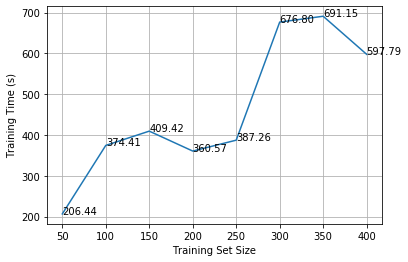

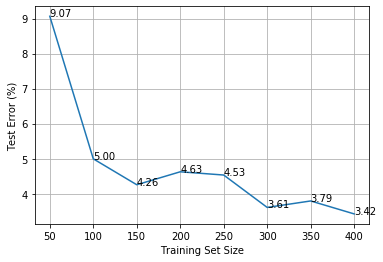

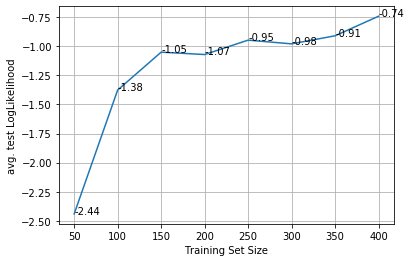

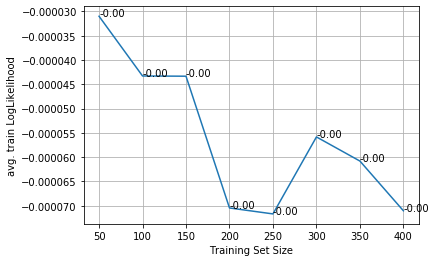

In [139]:
import matplotlib.pyplot as plt
fig = plt.figure()

lists = sorted(_training_times_bfgs.items())
x, y = zip(*lists)
# ax1 = fig.add_subplot(311)
plt.plot(x, y)
plt.grid(True)
plt.xlabel('Training Set Size')
plt.ylabel('Training Time (s)')
for xx, yy in zip(x, y):                                
    plt.annotate('%.2f' % yy, xy=(xx, yy), xytext= (xx, yy), textcoords='data')
plt.savefig('trainingTime.jpg', bbox_inches='tight')
plt.show()

lists = sorted(_errors_bfgs.items())
# print(lists)
x, y = zip(*lists)
plt.xlabel('Training Set Size')
plt.ylabel('Test Error (%)')
plt.plot(x, y)
plt.grid(True)
for xx, yy in zip(x, y):                                    
    plt.annotate('%.2f' % yy, xy=(xx, yy), xytext= (xx, yy), textcoords='data')
plt.savefig('TestError.jpg', bbox_inches='tight')
plt.show()

lists = sorted(_testLL_bfgs.items())
x, y = zip(*lists)
plt.xlabel('Training Set Size')
plt.ylabel('avg. test LogLikelihood')
plt.plot(x, y)
plt.grid(True)
for xx, yy in zip(x, y):                                      
    plt.annotate('%.2f' % yy, xy=(xx, yy), xytext= (xx, yy), textcoords='data') 
plt.savefig('testLogLikelihood.jpg', bbox_inches='tight')
plt.show()

lists = sorted(_trainLL_bfgs.items())
x, y = zip(*lists)
plt.xlabel('Training Set Size')
plt.ylabel('avg. train LogLikelihood')
plt.plot(x, y)
plt.grid(True)
for xx, yy in zip(x, y):                                       
    plt.annotate('%.2f' % yy, xy=(xx, yy), xytext= (xx, yy), textcoords='data')
plt.savefig('trainLogLikelihood.jpg', bbox_inches='tight')
plt.show()

## Appendix
### Compare the runtime of likelihood computation with and without preloaded TrainingData

In [247]:
_start = time.time()
for i in range(10):
    ll = 0
    for trainWordIdx in range(0, dataSize):
        trainWord = pd.read_csv(PATH + 'data/train_img{}.txt'.format(trainWordIdx+1), header=None, delimiter=" ")
        trainWord = trainWord.values
        trainWord_label = train_labels[trainWordIdx]
        trainWord_labelIdxs = [CharMapping[x] for x in trainWord_label]

        trainWordPhis = computePotentials(trainWord, feature_params)
        trainWordlogM = messageDict(trainWord, feature_params, transition_params)
        marginal = trainWordPhis[:, 0] + trainWordlogM[(2, 1)]
        logZ = logsumexp(marginal)

        trainWordEnergy = computeEnergy(trainWord, trainWord_label, trainWordPhis, transition_params)
        ll += trainWordEnergy - logZ

_end = time.time()
print(_end - _start)

21.01706337928772


In [248]:
_start = time.time()
AlltrainWords = []
for trainWordIdx in range(0, dataSize):
    trainWord = pd.read_csv(PATH + 'data/train_img{}.txt'.format(trainWordIdx+1), header=None, delimiter=" ")
    trainWord = trainWord.values
    AlltrainWords.append(trainWord)
    
for i in range(10):
    ll = 0
    for trainWordIdx in range(0, dataSize):
        trainWord = AlltrainWords[trainWordIdx]
        trainWord_label = train_labels[trainWordIdx]

        trainWordPhis = computePotentials(trainWord, feature_params)
        trainWordlogM = messageDict(trainWord, feature_params, transition_params)
        marginal = trainWordPhis[:, 0] + trainWordlogM[(2, 1)]
        logZ = logsumexp(marginal)

        trainWordEnergy = computeEnergy(trainWord, trainWord_label, trainWordPhis, transition_params)
        ll += trainWordEnergy - logZ

_end = time.time()
print(_end - _start)

5.523927927017212
